# Accessing ITS_LIVE data via S3 bucket

This notebook will demonstrate how to access cloud-hosted Inter-mission Time Series of Land Ice Velocity and Elevation ([ITS_LIVE](https://its-live.jpl.nasa.gov/#access)) data from AWS S3 buckets. Here you will find examples of how to successfully access cloud-hosted data as well as some common errors and issues you may run into along the way, what they mean, and how to resolve them. 

*Learning goals:*
- accessing data stored in S3 buckets

```{note}
This tutorial was updated Fall 2023 to reflect changes to ITS_LIVE data urls and various software libraries
```

In [2]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [41]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr

from shapely.geometry import Polygon
from shapely.geometry import Point
import hvplot.pandas
import hvplot.xarray

import json
import s3fs

%config InlineBackend.figure_format='retina'


In [4]:
%watermark

Last updated: 2023-11-04T08:24:00.848059-06:00

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.19.0-76051900-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit



In [5]:
%watermark --iversions

geopandas: 0.13.0
hvplot   : 0.8.4
s3fs     : 2023.5.0
json     : 2.0.9
xarray   : 2023.5.0
rioxarray: 0.14.1
numpy    : 1.24.3



## ITS_LIVE data cube catalog

The ITS_LIVE project details a number of data access options on their [website](https://its-live.jpl.nasa.gov/#access). Here, we will be accessing ITS_LIVE data in the form of `zarr` data cubes that are stored in **s3 buckets** hosted by Amazon Web Services (AWS). 

Let's begin by looking at the GeoJSON data cubes catalog. Click this [link](https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json) to download the file. This catalog contains spatial information and properties of ITS_LIVE data cubes as well as the URL used to access each cube. Let's take a look at the entry for a single data cube and the information that it contains:

![itslive_info](images/screengrab_itslive_catalog_entry.png)

The top portion of the picture shows the spatial extent of the data cube in lat/lon units. Below that, we have properties such as the epsg code of the coordinate reference system, the spatial footprint in projected units and the url of the zarr object. 

Let's take a look at the url more in-depth: 

![itslive_url](images/itslive_url.png)

From this link we can see that we are looking at its_live data located in an s3 bucket hosted by amazon AWS. We cans see that we're looking in the data cube directory and what seems to be version 2. The next bit gives us information about the global location of the cube (N40E080). The actual file name `ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr` tells us that we are looking at ice velocity data (its_live also has elevation data), in the CRS associated with EPSG 32645 (this code indicates UTM zone 45N). X250000_Y4750000 tells us more about the spatial footprint of the datacube within the UTM zone. 


## Accessing ITS_LIVE data from python

We've found the url associated with the tile we want to access, let's try to open the data cube using `xarray`:

In [20]:
url1 = 'http://its-live-data.s3.amazonaws.com/datacubes/v2/N30E090/ITS_LIVE_vel_EPSG32646_G0120_X750000_Y3350000.zarr'
dc1 = xr.open_dataset(url1) 

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <?xml^ version="1.0" encoding="UTF-8"?><Error><Code>PermanentRedirect</Code><Message>The bucket you are attempting to access must be addressed using the specified endpoint. Please send all future requests to this endpoint.</Message><Endpoint>its-live-data.s3-us-west-2.amazonaws.com</Endpoint><Bucket>its-live-data</Bucket><RequestId>07X2ZTDCS22TXXXP</RequestId><HostId>yFKCOKIjclI4KLz9KmRqURIJ+FtnxZBK0Bsr+FzeU/1/L4PSXTyN7dyuUKxAGNErtA3rY3aKt8o=</HostId></Error>


OSError: [Errno -72] NetCDF: Malformed or inaccessible DAP2 DDS or DAP4 DMR response: 'http://its-live-data.s3.amazonaws.com/datacubes/v2/N30E090/ITS_LIVE_vel_EPSG32646_G0120_X750000_Y3350000.zarr'

As you can see, this doesn't quite work. Passing the url to `xr.open_dataset()` without specifying a backend, xarray will expect a netcdf file. Because we're trying to open a zarr file we need to add an additional argument to `xr.open_dataset()`, shown in the next code cell. You can find more information [here](https://docs.xarray.dev/en/stable/user-guide/io.html#cloud-storage-buckets). In the following cell, the argument `chunks="auto"` is passed, which introduces [dask](https://www.dask.org/) into our workflow.

In [21]:
dc1 = xr.open_dataset(url1S, engine= 'zarr', chunks="auto")
                                   # storage_options = {'anon':True}) <-- as of Fall 2023 this no longer needed

In [22]:
dc1

<xarray.Dataset>
Dimensions:                     (mid_date: 25243, y: 833, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2022-06-07T04:21:44...
  * x                           (x) float64 7.001e+05 7.003e+05 ... 8e+05
  * y                           (y) float64 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

This one worked! Let's stop here and define a function that we can use for a quick view of this data.


In [23]:
def get_bounds_polygon(input_xr):
    
    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

    crs = f"epsg:{input_xr.mapping.spatial_epsg}"

    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    
    return polygon

Let's also write a quick function for reading in s3 objects from http urls. This will come in handy when we're trying to test multiple urls

In [24]:
def read_in_s3(http_url, chunks = 'auto'):
    #s3_url = http_url.replace('http','s3')   <-- as of Fall 2023, can pass http urls directly to xr.open_dataset()
    #s3_url = s3_url.replace('.s3.amazonaws.com','')

    datacube = xr.open_dataset(http_url, engine = 'zarr',
                                #storage_options={'anon':True},
                                chunks = chunks)

    return datacube

Now let's take a look at the cube we've already read in:

In [25]:
bbox = get_bounds_polygon(dc1)

`get_bounds_polygon()` returns a geopandas.GeoDataFrame object in the same projection as the velocity data object (local UTM). Re-project to latitude/longitude to view the object more easily on a map:

In [26]:
bbox = bbox.to_crs('EPSG:4326')

In [27]:
poly = bbox.hvplot(legend=True,alpha=0.3, tiles='ESRI', color='red')

In [28]:
poly

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]

Now we can see where this granule lies. We are using `pandas.hvplot` here, which is a great tool for interactive data visualization. You can read more about it [here](https://hvplot.holoviz.org/user_guide/Introduction.html). Later in the tutorial we will demonstrate other situations where these tools are useful. 

## Searching ITS_LIVE catalog

Let's take a look at how we could search the ITS_LIVE data cube catalog for the data that we're interested in. There are many ways to do this, this is just one example. 

First, we will read in the catalog geojson file:

In [30]:
itslive_catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')


Here we'll show two options for filtering the catalog: 
1. one for selecting granules that contain a specific point, and 
2. one that returns all granules within a single UTM zone (specified by epsg code).  This will let us take stock of the spatial coverage of data cubes located at **working urls** within a certain UTM zone. 

You could easily tweak these functions (or write your own!) to select granules based on different properties. Play around with the `itslive_catalog` object to become more familiar with the data it contains and different options for indexing.

In [31]:
import s3fs
fs  = s3fs.S3FileSystem(anon=True)
fs

## Selecting granules by a single point

In [32]:
def find_granule_by_point(input_point):
    '''returns url for the granule (zarr datacube) containing a specified point. point must be passed in epsg:4326
    '''
    catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')

    #make shapely point of input point
    p = gpd.GeoSeries([Point(input_point[0], input_point[1])],crs='EPSG:4326')
    #make gdf of point
    gdf = gdf = gpd.GeoDataFrame({'label': 'point', 
                                  'geometry':p})
    #find row of granule 
    granule = catalog.sjoin(gdf, how='inner')

    url = granule['zarr_url'].values[0]
    return url


In [33]:
url = find_granule_by_point([95.180191, 30.645973])

Great, this function returned a single url corresponding to the data cube covering the point we supplied

In [34]:
url

'http://its-live-data.s3.amazonaws.com/datacubes/v2/N30E090/ITS_LIVE_vel_EPSG32646_G0120_X750000_Y3350000.zarr'

Let's use the `read_in_s3` function we defined to open the datacube as an `xarray.Dataset`

In [35]:
datacube = read_in_s3(url)

and then the `get_bounds_polyon` function to take a look at the footprint using `hvplot()`. Hvplot is an API for data exploration and visualization that you can read more about [here](https://hvplot.holoviz.org/).

In [36]:
bbox_dc = get_bounds_polygon(datacube)

In [37]:
poly =  bbox_dc.to_crs('EPSG:4326').hvplot(legend=True,alpha=0.3, tiles='ESRI', color='red')

In [38]:
poly

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]

Great, now we know how to access the its_live data cubes for a given region as well as at a specific point.

Let's take a quick first look at this data cube. The next notebooks will go into more examples of inspecting and working with this data. To make it easier for now, we will only plot a few hundred time steps instead of the full time series:

In [39]:
datacube_sub = datacube.isel(mid_date = slice(0,50))

Use the `vmax` argument to set a maximum value for the plot:

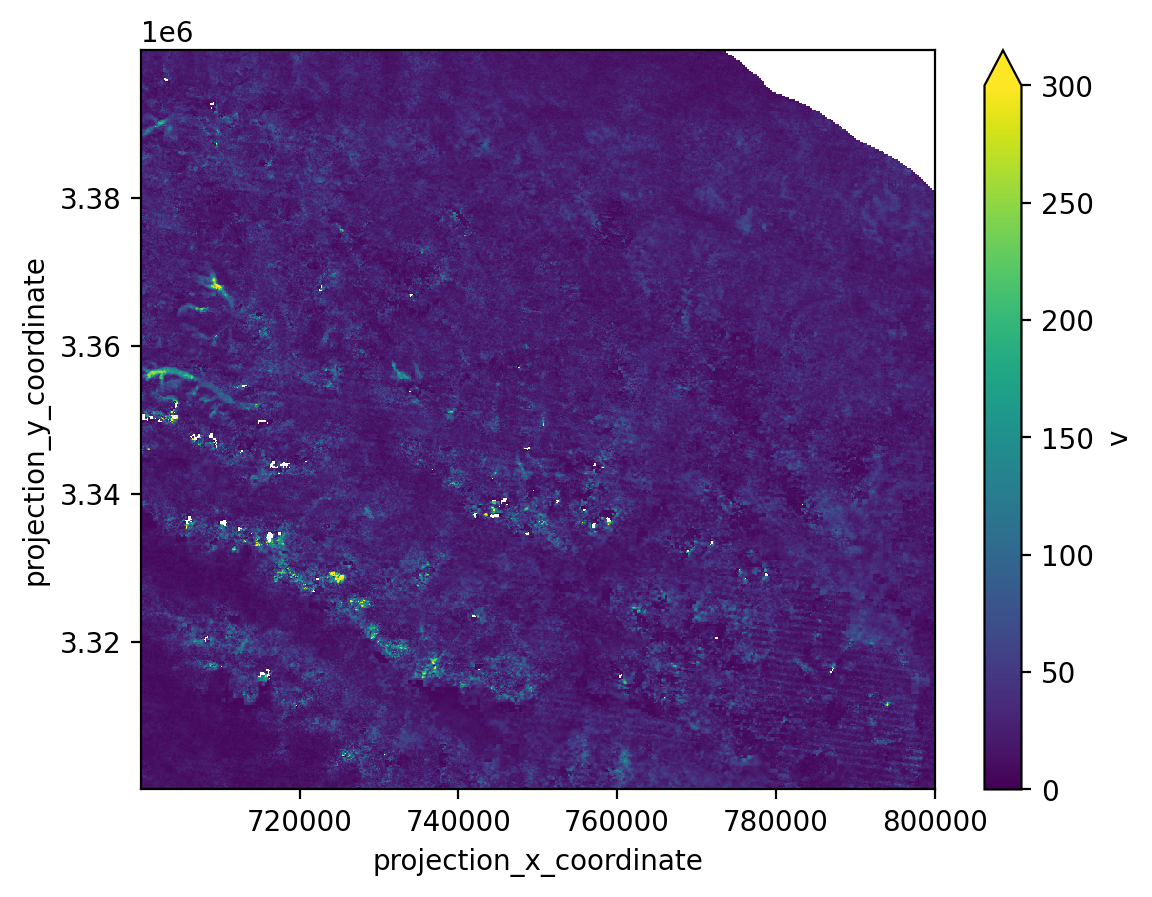

In [40]:
datacube_sub.v.mean(dim='mid_date').plot(vmax=300)

The above plot shows the mean of the magnitude of velocity variable along the time dimension. The rest of the notebooks in this chapter will demonstrate how to subset this spatially-large data object to specific areas of interest.

### Conclusion

- This notebook demonstrated how to query and access zarr data cubes from the ITS_LIVE dataset. We also looked at reading data into python using `xarray`, introducing `dask` to our workflows, and some preliminary data visualization.
- The next notebook in the tutorial will take a look at the dataset in more detail and demonstrate ways to organize and manipulate data using `xarray`. 